# Classifying satelite images from Planet labs dataset using Retrained Resnet50

In this notebook we implement multilabel classification using a pretrained Resnet-50 on the dataset from [Planet Lab's understanding the Amazon from space competition.](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)

This code is heavly inspired from [FastAI library](https://github.com/fastai/fastai) and was written for better understanding it.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from Planet.data import PlanetDataCollection
from Planet.model import PlanetClassifer
from Planet.callbacks.scheduler import ParamScheduler
from Planet.callbacks.training import LR_Find, CudaCallback
from Planet.callbacks.stats import AvgStatsCallback
from Planet.utils.scheduler import combine_scheds, sched_cos
from Planet.callbacks.logger import Logger
from Planet.utils.basic import get_transforms, get_df
from Planet.utils.metrics import acc_thresh, fbeta
from Planet.train import NNTrainer 
from torchvision import models
from pathlib import Path

In [3]:
import torch
from torch import nn
from torch import optim
from functools import partial

In [4]:
path = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/Planet')

In [5]:
tfms = get_transforms()

In [6]:
data = PlanetDataCollection.from_csv(path, 'train_v2.csv', 'train-jpg',
                           tfms, name_col='image_name', label_col='tags',
                           delimter=' ',bs=64,test_folder='test-jpg')

### Visualizing the Images
This is a random sample of images taken from the training set. Each image is labeled with all the features that are present in the image. Since a image could contain multiple features we should consider this as a multi-label classification problem. 

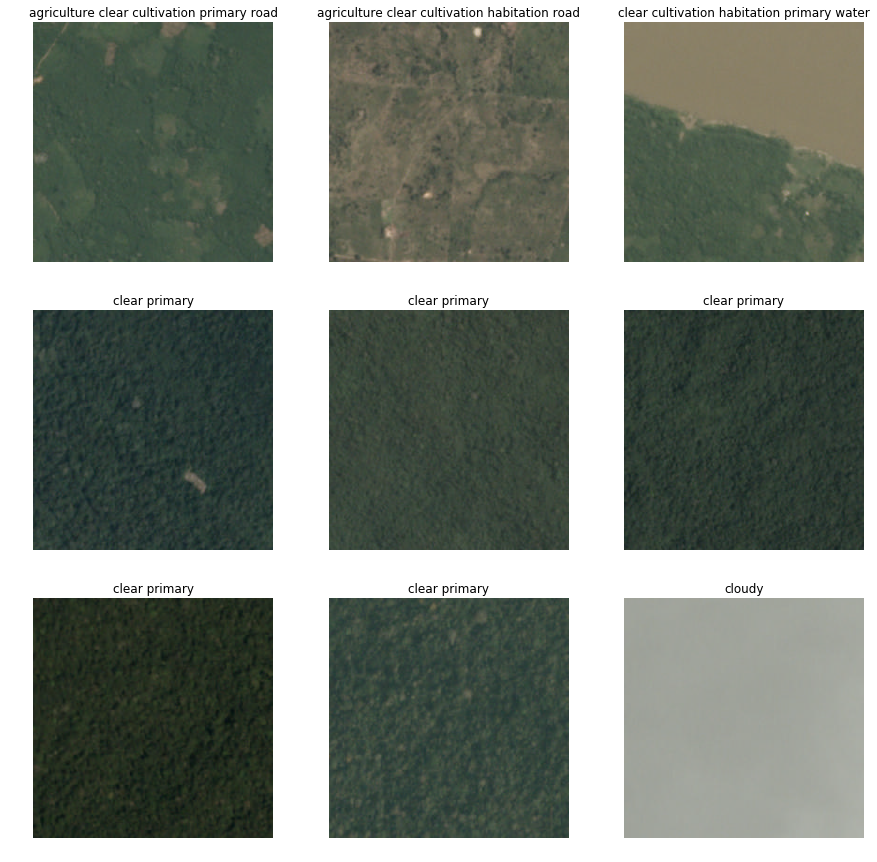

In [7]:
data.show()

## Data Augmentation through Transforms

Data augmentation is a technique where synthetic data is generated based off the input data. This has great impact on learning efficency, but there is a need to be careful, the augmentation should be done in such a manner that the generated data still belongs to the orignal data label.

For eg in this problem satelite images are classified on the basis of presence and absence of certain features like rivers, roads, primary rainforest etc. These features remain the same even if I were to flip the images horizontally and vertically as these would still be roads and rivers just moving in a different directions.

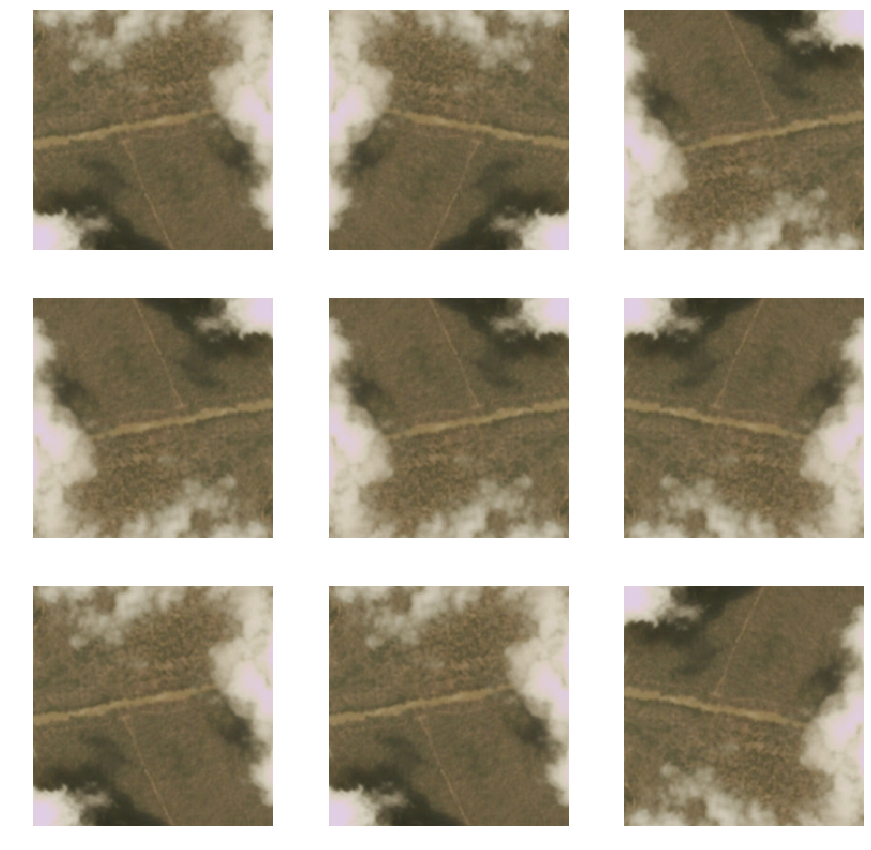

In [8]:
data.show_tfms()

Such approach may not work as well when working with say faces where a face upside down may not be the best idea.( a horizontal flip still may work.)

## Model Optimizer and Loss function

The model is a Resnet pretrained on imagenet, which is finetuned by replaceing the final fully connected layers with new ones such that the number of outputs is equal to number of classes.

As the problem is a multi-label classification problem, `Binary Cross Entropy` loss with `Sigmoid` output would be a good choice. Pytorch contains the model `nn.BCEWithLogitsLoss` which is a combination of a BCE loss applied after a sigmoid layer.

Optimizer used is Adam.

In [9]:
def get_basic():
    arch = models.resnet50
    model = PlanetClassifer(arch, output_sz=data.c)
    loss_func = nn.BCEWithLogitsLoss()
    opt = optim.Adam(model.parameters())
    return model, loss_func, opt

## Finding Learing Rate

For choosing an appropriate learning rate we use the approach discribed in the paper [`Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith`](https://arxiv.org/abs/1506.01186).

In [10]:
finder = NNTrainer(data,*get_basic(), cb_funcs=[LR_Find, Logger, CudaCallback])

In [11]:
finder.fit(2)

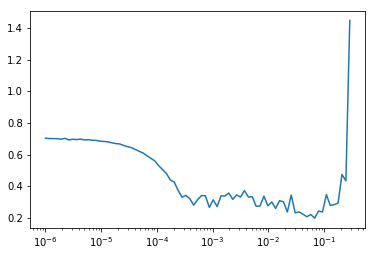

In [12]:
finder.logger.plot(skip_last=1)

## Training

In [13]:
model,loss_func, opt = get_basic()

In [14]:
sched1 = combine_scheds([0.3, 0.7], [sched_cos(3e-3, 1e-2), sched_cos(1e-2, 3e-5)])
sched2 = combine_scheds([0.3, 0.7], [sched_cos(3e-5, 1e-3), sched_cos(1e-3, 1e-5)])

In [15]:
trainer = NNTrainer(data,model, loss_func, opt, cbs=[ParamScheduler('lr', sched1),
                                                     AvgStatsCallback([partial(acc_thresh, thresh=0.2),
                                                                       partial(fbeta, beta=1)])], cb_funcs=[Logger, CudaCallback])

In [16]:
trainer.fit(4)

/home/anukoolpurohit/Documents/Workspace/MachineLearningExperiment/PlanetTransferPytorch/Planet/utils/scheduler.py:31: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


     epoch        train_loss    train_acc_thresh   train_fbeta     valid_loss    valid_acc_thresh   valid_fbeta   time [min:sec] 
       0           0.160792        0.939442        0.811449        0.146884        0.943472        0.813173          07:55     


       1           0.159607        0.940274        0.813501        0.135327        0.947476        0.828076          03:20     


       2           0.142184        0.946103        0.832997        0.125978        0.950084        0.844258          03:27     


       3           0.130765        0.949723        0.846766        0.119516        0.953405        0.857662          03:24     


In [17]:
trainer.model.save('frozen1')

In [18]:
trainer.model.unfreeze()

In [19]:
trainer.remove_cbs([trainer.param_scheduler])
trainer.add_cb(ParamScheduler('lr', sched2))

In [20]:
trainer.fit(4)

     epoch        train_loss    train_acc_thresh   train_fbeta     valid_loss    valid_acc_thresh   valid_fbeta   time [min:sec] 
       0           0.125171        0.952211        0.853626        0.128057        0.951792        0.852167          05:29     


       1           0.112662        0.957270        0.871048        0.102499        0.961194        0.882917          05:38     


       2           0.100917        0.961468        0.886952        0.093998        0.964013        0.891319          05:45     


       3           0.089036        0.965674        0.900656        0.088032        0.965960        0.901963          05:40     


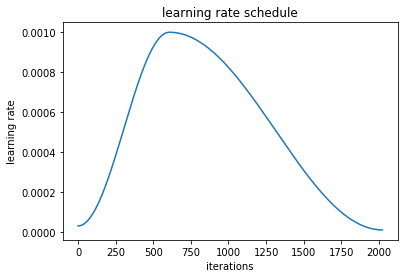

In [21]:
trainer.logger.plot_lr()

In [22]:
trainer.model.save('done')

In [23]:
trainer.model.load('done')

## Predictions on Test set

In [24]:
preds = trainer.predict_test()

In [25]:
df = get_df(preds,data)

In [26]:
data2 = PlanetDataCollection.from_csv(path, 'train_v2.csv', 'train-jpg',
                           tfms, name_col='image_name', label_col='tags',
                           delimter=' ',bs=64,test_folder='test-jpg-additional')

trainer.data = data2

In [27]:
preds2 = trainer.predict_test()

In [28]:
df2 = get_df(preds2, data2)

In [29]:
import pandas as pd
df3 = pd.concat([df, df2])

In [30]:
df3.to_csv('strange_submission.csv', index=False)